# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1.0 Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')

## 2.0 Analyze correlation between all events (n=12573) and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [3]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [4]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

lwe_data = ds.lwe_thickness
cap_radius_deg = 1.5  # Spherical cap radius in degrees

In [5]:
'''
Full catalog - Convert earthquake data to a GeoDataFrame
'''
# Convert lon and lat to Shapely Point objects
geometry_full = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]

# GeoDataFrame for the full earthquake catalog
catalog_gdf_full = gpd.GeoDataFrame(catalog, geometry=geometry_full, crs="EPSG:4326")  
# EPSG:4326 specifies the coordinate reference system (WGS 84)
catalog_gdf_full.sindex

'''
ETAS Declustered Catalog - Convert ETAS declustered earthquake data to a GeoDataFrame
'''
# Convert ETAS catalog's coordinates into Shapely Point objects
geometry_etas = [Point(xy) for xy in zip(etas_declustered['longitude'], etas_declustered['latitude'])]

# GeoDataFrame for the ETAS declustered catalog
catalog_gdf_etas = gpd.GeoDataFrame(etas_declustered, geometry=geometry_etas, crs="EPSG:4326")
catalog_gdf_etas.sindex

In [73]:
def calc_cp_by_mascon_lag(catalog_gdf, loads, taus):
    """
    Calculates conditional probability P(E|L_tau) in every mascon using each mascon's center coordinates 
    and creating a 1.5-degree radius spherical cap around each one.
    
    Parameters:
    -----------
    catalog_gdf: Earthquake catalog with 'time' (datetime64) and 'dmass' columns.
    loads:       GRACE-derived surface load dataset with 'time', 'lat', 'lon' dimensions.
    taus:        Lags (in months) to test. Default = np.arange(1, 13).
    
    Returns:
    --------
    cp_tau_mean: Mean conditional probabilities across mascons for each lag.
    bins:        Bin edges for load values.
    taus:        Array of tau values in months.
    """

    grace_times = loads.time.values.astype("datetime64[M]")  # monthly timestamps
    cp_all_mascons = []
    used_mascon_ids = []

    for i in range(len(mascon_id)):
        
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])
        bbox = center_point.buffer(cap_radius_deg)
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Find earthquakes inside this mascon
        these_eq = gpd.sjoin(catalog_gdf, bbox_gdf, how="inner", predicate="within")
        if these_eq.empty:
            continue

        # Extract loads for this mascon
        L = loads.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # For each earthquake, find nearest GRACE time index
        eq_times = these_eq["time"].values.astype("datetime64[M]")
        t_indices = np.array([np.argmin(np.abs(grace_times - t)) for t in eq_times])

        cp_by_tau = []

        for tau in taus:
            # Shift earthquake indices by lag tau
            lag_indices = t_indices - tau
            valid_mask = (lag_indices >= 0)

            if not np.any(valid_mask):
                cp_by_tau.append(np.full_like(np.histogram(L, bins=np.linspace(-80, 80, 80))[0], np.nan, dtype=float))
                continue

            # Get lagged loads corresponding to valid earthquakes
            LgE_tau = L[lag_indices[valid_mask]]

            # Compute conditional probability for this tau
            bins = np.linspace(-80, 80, 80)
            LgE_hist = np.histogram(LgE_tau, bins=bins, density=True)[0]
            L_hist = np.histogram(L, bins=bins, density=True)[0]
            cp_tau = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)
    
            # Weight by number of earthquakes
            E = np.sum(valid_mask)
            cp_by_tau.append(cp_tau * E)

        cp_all_mascons.append(np.vstack(cp_by_tau))  # shape (n_tau, n_bins)
        used_mascon_ids.append(mascon_id[i])
        
    cp_all_mascons = np.array(cp_all_mascons)  # shape (n_mascon, n_tau, n_bins)
    # cp_tau_mean = np.nanmean(cp_all_mascons, axis=0)  # average cp (given a tau lag) across all mascons

    return used_mascon_ids, cp_all_mascons, bins, taus

In [74]:
used_mascon_ids_all, cp_all, bins, taus = calc_cp_by_mascon_lag(catalog_gdf_full, lwe_data, np.arange(1, 13))

### 2.1 Assign mascon_id to each event

In [82]:
def assign_mascon_id(eq, mascon_center_lon, mascon_center_lat, mascon_id):

    # Euclidean distance
    d2 = (mascon_center_lon - eq["longitude"])**2 + (mascon_center_lat - eq["latitude"])**2
    idx = np.argmin(d2)
    return mascon_id[idx]

In [83]:
catalog_gdf_full["mascon_id"] = catalog_gdf_full.apply(
    lambda row: assign_mascon_id(row, mascon_center_lon, mascon_center_lat, mascon_id),
    axis=1
)

## 3.0 Analyze correlation between events in declustered catalog (n=537) and surface mass loading by mascon

In [85]:
etas_used_mascon_ids, etas_cp_all, etas_bins, etas_taus = calc_cp_by_mascon_lag(catalog_gdf_etas, lwe_data, np.arange(1, 13))

### 3.1 Assign mascon_id to each event

In [86]:
catalog_gdf_etas["mascon_id"] = catalog_gdf_etas.apply(
    lambda row: assign_mascon_id(row, mascon_center_lon, mascon_center_lat, mascon_id),
    axis=1dewe
)

#### Now, we have calculated a conditional probability (cp) curve for every mascon, therefore, for every event. Every event in the same mascon has the same cp curve.

## 4.0 Visualizing correlation for full & declustered catalog

(array([ 1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  3.,  1.,  1.,
         0.,  8.,  0., 11.,  0., 10.,  0.,  5.,  4.,  0., 10.,  0.,  7.,
         0.,  1.,  9.,  0.,  2.,  2.,  0.,  3.,  0.,  0.,  2.,  0.,  1.,
         1.,  0.,  4.,  1.,  0.,  1.,  1.,  0.,  6.,  0.,  1.,  5.,  0.,
         1.,  2.,  0.,  3.,  3.,  0.,  5.,  2.,  0.,  3.,  1.,  0.,  4.,
         0.,  0.,  1.,  0.,  1.,  1.,  0.,  3.,  2.,  0.,  2.,  0.,  1.,
         1.,  0.,  3.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,
         0.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,  1.]),
 array([  37.  ,   78.47,  119.94,  161.41,  202.88,  244.35,  285.82,
         327.29,  368.76,  410.23,  451.7 ,  493.17,  534.64,  576.11,
         617.58,  659.05,  700.52,  741.99,  783.46,  824.93,  866.4 ,
         907.87,  949.34,  990.81, 1032.28, 1073.75, 1115.22, 1156.69,
        1198.16, 1239.63, 1281.1 , 1322.57, 1364.04, 1405.51, 1446.98,
        1488.45, 1529.92, 1571.39, 1612.86, 1654.33, 1695.8 , 1737.27,
        

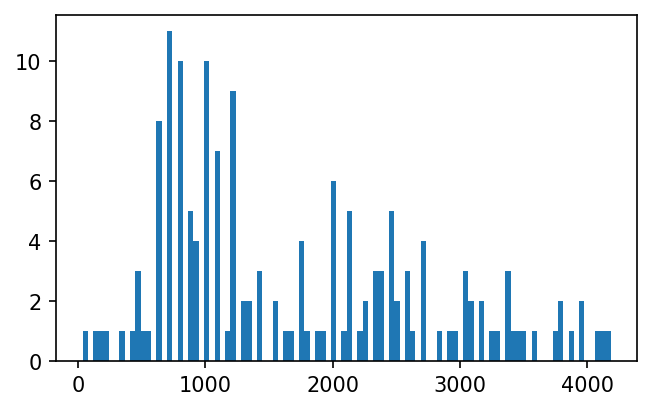

In [120]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
ax.hist(etas_used_mascon_ids, 100)

4087.0
37.0


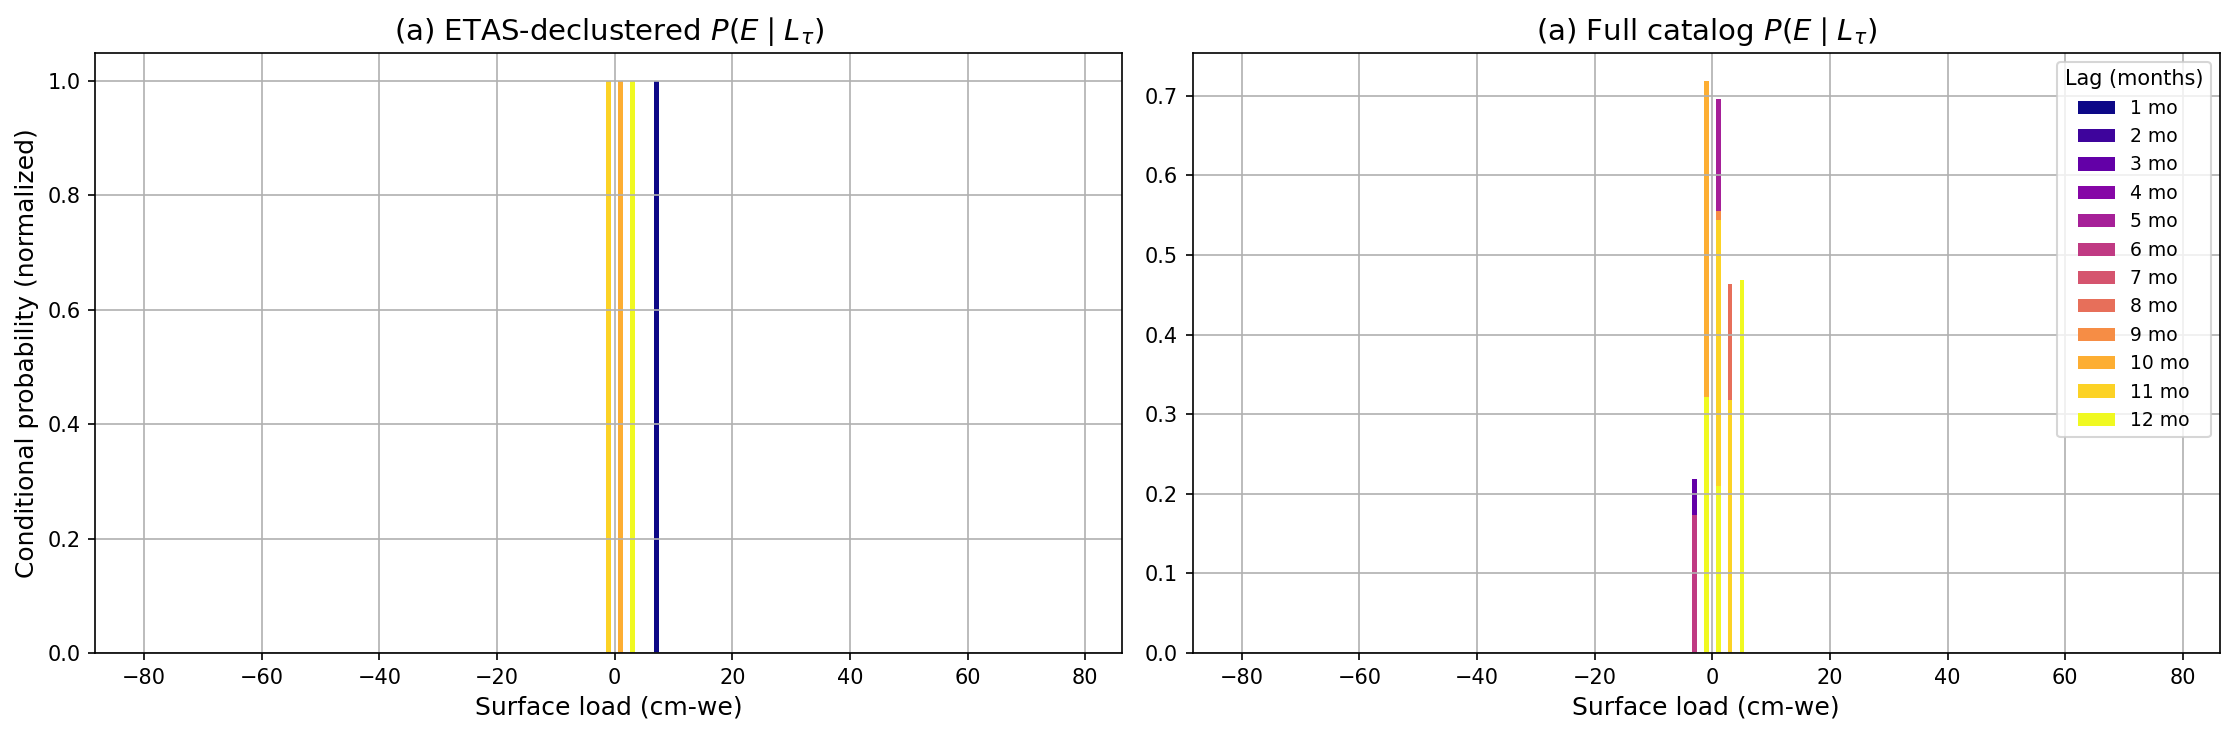

In [142]:
# Choose which mascon to plot

masc_id = 350;
etas_masc_idx = 1;

chosen_mascon = used_mascon_ids_all[masc_idx-1]
print(chosen_mascon)
etas_chosen_mascon = etas_used_mascon_ids[etas_masc_idx-1]
print(etas_chosen_mascon)

cp_tau_chosen = cp_all[masc_idx-1]
etas_cp_tau_chosen = etas_cp_all[etas_masc_idx-1]

# Normalize each by its sum for comparability
cp_tau_norm = cp_tau_chosen / np.nansum(cp_tau_chosen, axis=1)[:, None]
etas_cp_tau_norm = etas_cp_tau_chosen / np.nansum(etas_cp_tau_chosen, axis=1)[:, None]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
fs = 12
colors = plt.cm.plasma(np.linspace(0, 1, len(taus)))

# (a) ETAS-declustered
for i, tau in enumerate(etas_taus):
    axes[0].bar(etas_bins[:-1], etas_cp_tau_norm[i], color=colors[i], label=f'{tau} mo')

axes[0].set_title(r'(a) ETAS-declustered $P(E\mid L_{\tau})$', fontsize=fs+2)
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Conditional probability (normalized)', fontsize=fs)
axes[0].grid(True)

# (b) Full catalog
for i, tau in enumerate(taus):
    axes[1].bar(bins[:-1], cp_tau_norm[i], color=colors[i], label=f'{tau} mo')

axes[1].set_title(r'(a) Full catalog $P(E \mid L_{\tau})$', fontsize=fs+2)
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)
# axes[1].set_ylabel('Conditional probability (normalized)', fontsize=fs)
axes[1].grid(True)
axes[1].legend(title='Lag (months)', fontsize=9)

plt.tight_layout()
plt.show()

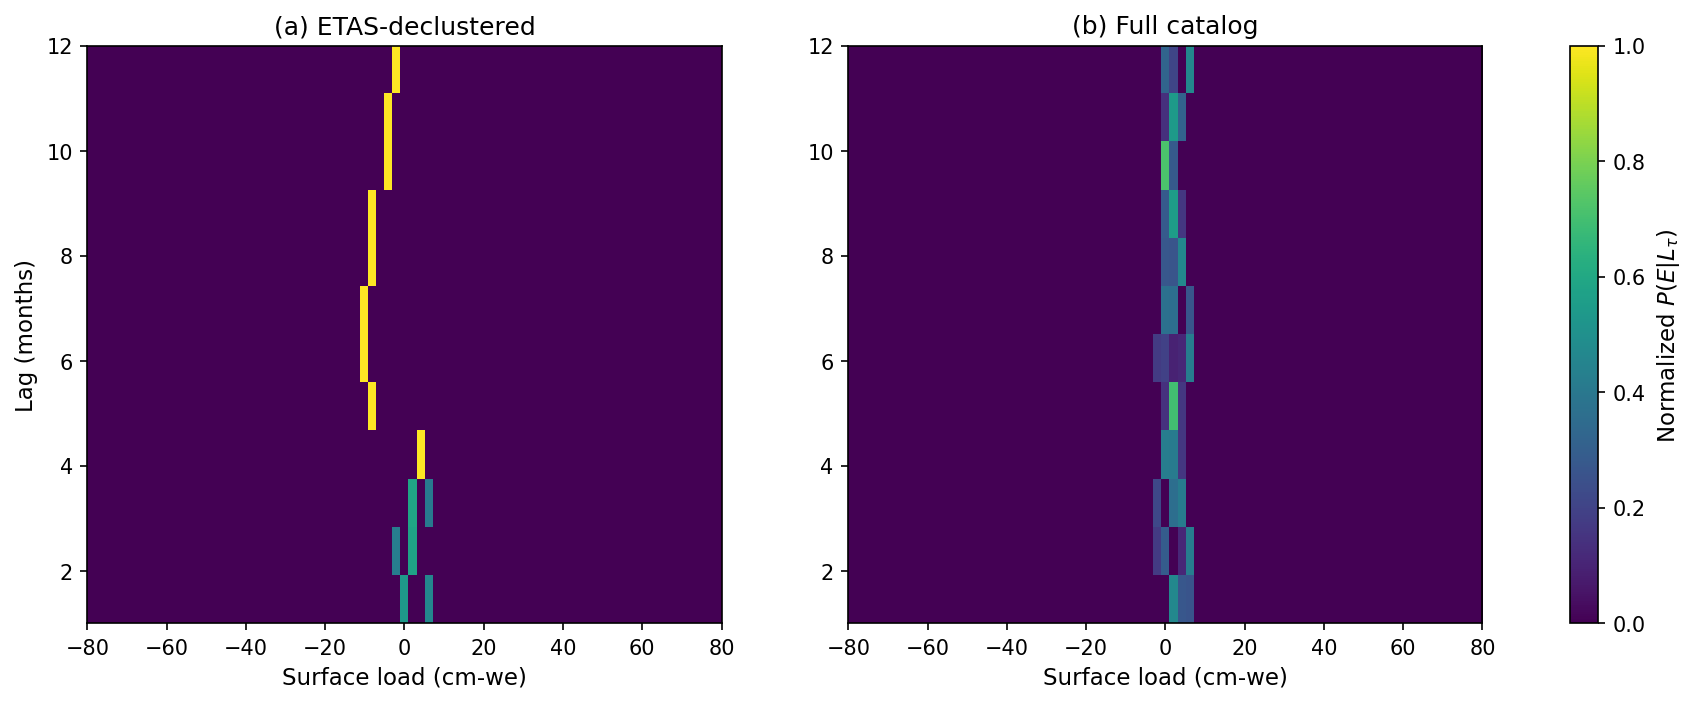

In [137]:
vmin = min(np.nanmin(etas_cp_tau_norm), np.nanmin(cp_tau_norm))
vmax = max(np.nanmax(etas_cp_tau_norm), np.nanmax(cp_tau_norm))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# (a) ETAS-declustered 
im1 = axes[0].imshow(
    etas_cp_tau_norm,
    aspect='auto',
    origin='lower',
    extent=[etas_bins[0], etas_bins[-1], etas_taus[0], etas_taus[-1]],
    cmap='viridis',
    vmin=vmin, vmax=vmax
)

# # Overlay significance thresholds
# contours = axes[0].contour(
#     bins[:-1], taus, etas_cp_tau_norm, 
#     levels=[0.0771, 0.1248], 
#     colors=['C1', 'C3'], 
#     linewidths=1.5
# )

axes[0].set_title('(a) ETAS-declustered', fontsize=12)
axes[0].set_xlabel('Surface load (cm-we)', fontsize=11)
axes[0].set_ylabel('Lag (months)', fontsize=11)

# (b) Full catalog 
im2 = axes[1].imshow(
    cp_tau_norm,
    aspect='auto',
    origin='lower',
    extent=[bins[0], bins[-1], taus[0], taus[-1]],
    cmap='viridis',
    vmin=vmin, vmax=vmax
)

axes[1].set_title('(b) Full catalog', fontsize=12)
axes[1].set_xlabel('Surface load (cm-we)', fontsize=11)

# # Overlay significance thresholds
# contours = axes[1].contour(
#     bins[:-1], taus, cp_tau_norm, 
#     levels=[0.0701, 0.0906], 
#     colors=['C1', 'C3'], 
#     linewidths=1.5
# )


cbar = fig.colorbar(im2, ax=axes, orientation='vertical')
cbar.set_label('Normalized $P(E|L_{\\tau})$', fontsize=11)

plt.show()


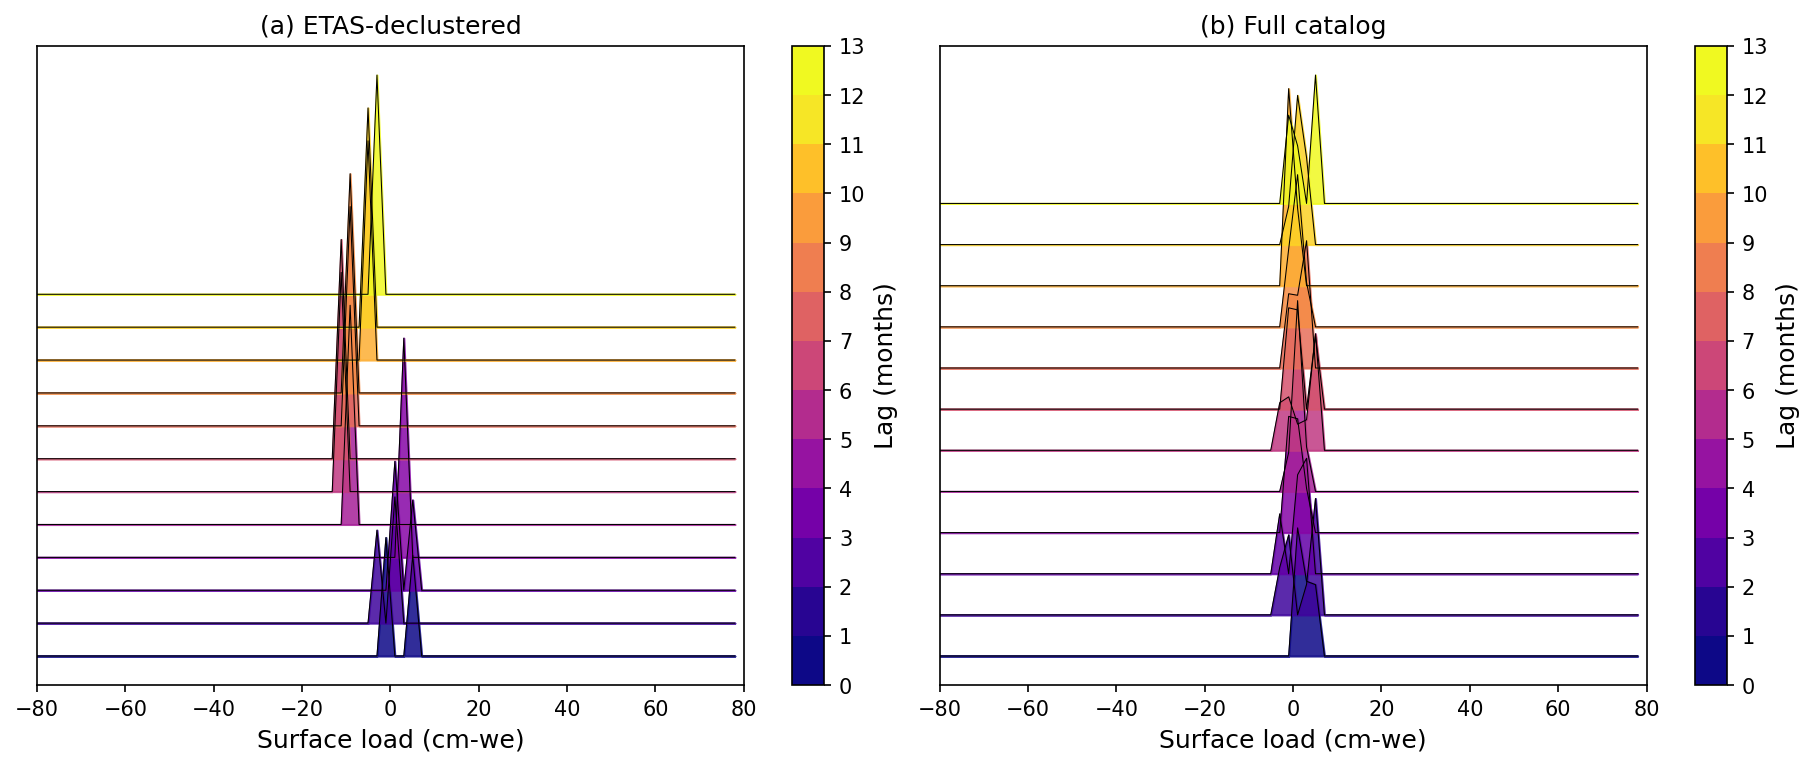

In [138]:

fs=12
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150, constrained_layout=True)

spacing = 0.15
colors = plt.cm.plasma(np.linspace(0, 1, len(taus)))

# (a) ETAS-declustered
offset = 0
ax = axes[0]
for i, tau in enumerate(taus):
    y = etas_cp_tau_norm[i]
    ax.fill_between(bins[:-1], offset, y + offset, color=colors[i], alpha=0.85)
    ax.plot(bins[:-1], y + offset, color='k', lw=0.5)
    offset += spacing
ax.set_title('(a) ETAS-declustered', fontsize=fs)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_xlim(bins[0], bins[-1])
ax.set_yticks([])

norm = mpl.colors.Normalize(vmin=min(taus), vmax=max(taus)) 
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm) 
sm.set_array([]) 
bounds = np.linspace(0, 13, 14) 
cbar = plt.colorbar(sm, ax=ax, pad=0.05, ticks=bounds,boundaries=bounds) 
cbar.set_label('Lag (months)', fontsize=fs)

# (b) Full catalog
offset = 0
ax = axes[1]
for i, tau in enumerate(taus):
    y = cp_tau_norm[i]
    ax.fill_between(bins[:-1], offset, y + offset, color=colors[i], alpha=0.85)
    ax.plot(bins[:-1], y + offset, color='k', lw=0.5)
    offset += spacing
    
ax.set_title('(b) Full catalog', fontsize=fs)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_xlim(bins[0], bins[-1])
ax.set_yticks([])

cbar = plt.colorbar(sm, ax=ax, pad=0.05, ticks=bounds,boundaries=bounds) 
cbar.set_label('Lag (months)', fontsize=fs)



plt.show()

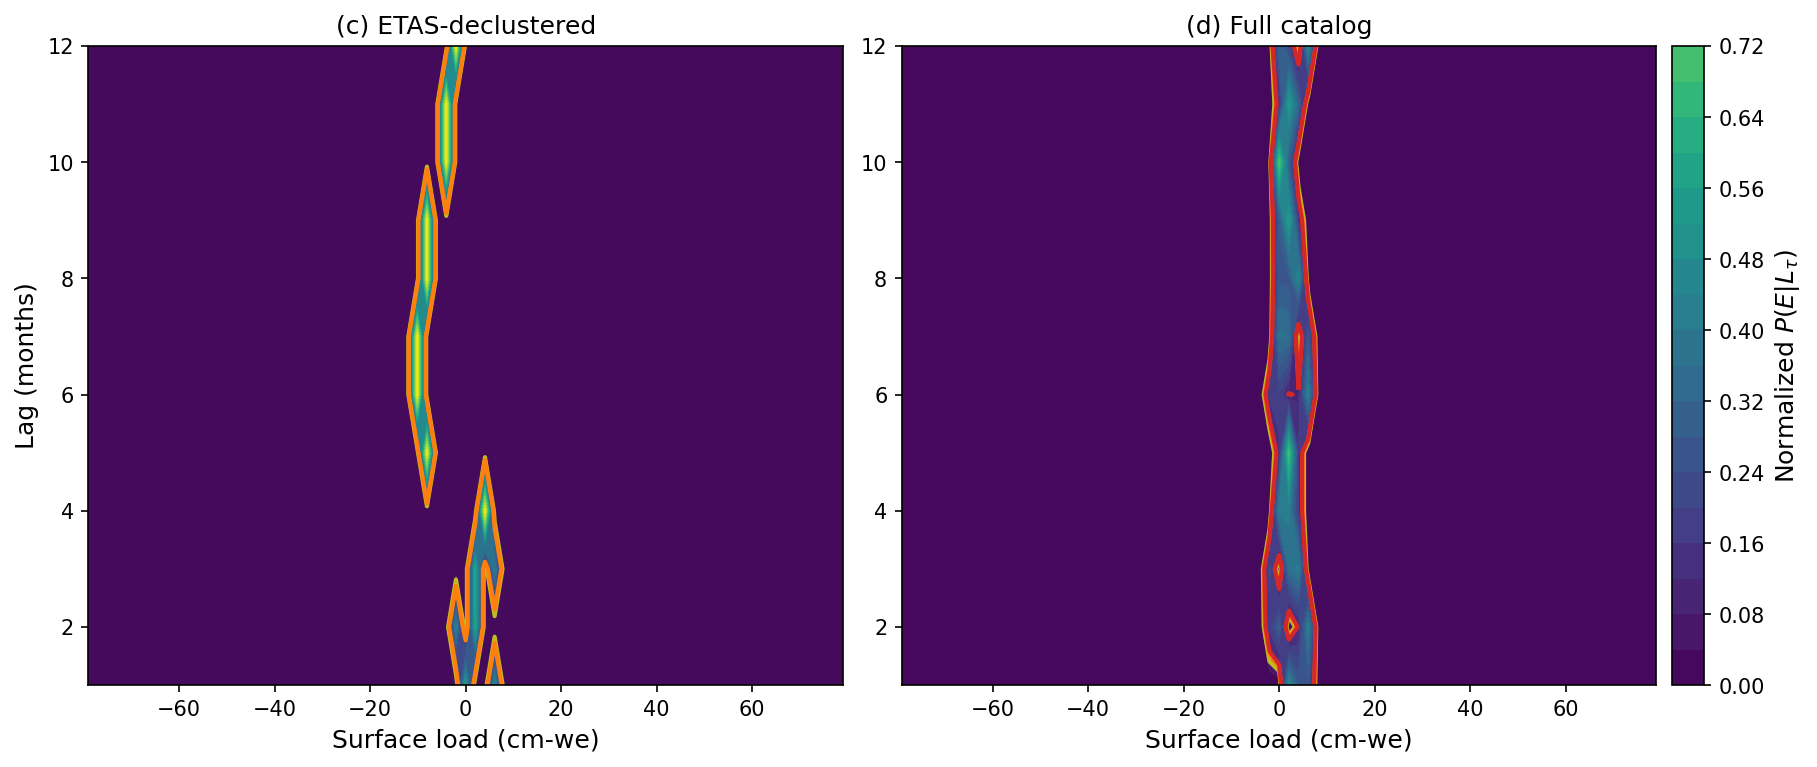

In [139]:
fs=12

# Shared vmin/vmax for consistent color scaling
vmin = min(np.nanmin(etas_cp_tau_norm), np.nanmin(cp_tau_norm))
vmax = max(np.nanmax(etas_cp_tau_norm), np.nanmax(cp_tau_norm))

etas_bin_centers = 0.5 * (etas_bins[:-1] + etas_bins[1:])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

X1, Y1 = np.meshgrid(etas_bin_centers, etas_taus)
X2, Y2 = np.meshgrid(bin_centers, taus)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150, constrained_layout=True)

# (a) ETAS-declustered 
cf1 = axes[0].contourf(
    X1, Y1, etas_cp_tau_norm,
    levels=20, cmap='viridis',
    vmin=vmin, vmax=vmax
)
# Add significance contour lines on top (smoothed levels)
axes[0].contour(
    X1, Y1, etas_cp_tau_norm,
    levels=[0.0771, 0.1248],
    colors=['C8', 'C1'],
    linewidths=2
)
axes[0].set_title('(c) ETAS-declustered', fontsize=fs)
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Lag (months)', fontsize=fs)

# (b) Full catalog 
cf2 = axes[1].contourf(
    X2, Y2, cp_tau_norm,
    levels=20, cmap='viridis',
    vmin=vmin, vmax=vmax
)
axes[1].contour(
    X2, Y2, cp_tau_norm,
    levels=[0.0701, 0.0906, 0.1018],
    colors=['C8', 'C1', 'C3'],
    linewidths=2
)
axes[1].set_title('(d) Full catalog', fontsize=fs)
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)

cbar = fig.colorbar(cf2, ax=axes, orientation='vertical', fraction=0.046, pad=0.01)
cbar.set_label('Normalized $P(E|L_{\\tau})$', fontsize=fs)

plt.show()
